In this project I will build a model that predicts maximum bouldering grade

In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from xgboost import plot_importance

In [9]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Data exploration

There are 4 tables included in this dataset. Ascents describes the individual climbs each climber logged and user describes each of the climbers. Method and grades describe details about the types of climbs. 

In [6]:
ascents = pd.read_csv('ascents.csv')
grades = pd.read_csv('grades.csv')
method = pd.read_csv('method.csv')
user = pd.read_csv('user.csv')

/var/folders/h2/yfy4kgfn3l7_c6byc_fnzq340000gn/T/ipykernel_16781/1074713445.py:2: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  ascents = pd.read_csv('ascents.csv')
/var/folders/h2/yfy4kgfn3l7_c6byc_fnzq340000gn/T/ipykernel_16781/1074713445.py:5: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  user = pd.read_csv('user.csv')


In [101]:
ascents.head(10)
print("table dimensions:", ascents.shape)

,id,user_id,grade_id,notes,raw_notes,method_id,climb_type,total_score,date,year,...,country,comment,rating,description,yellow_id,climb_try,repeat,exclude_from_ranking,user_recommended,chipped
0,2,1,36,NaN,0,3,0,545,918342000,1999,...,THA,Thailand\n,0,NaN,255,0,0,0,0,0
1,3,1,36,NaN,0,3,0,545,925509600,1999,...,NaN,\n,0,NaN,0,0,0,0,0,0
2,4,1,36,NaN,0,3,0,545,933026400,1999,...,SWE,\n,0,NaN,255,0,0,0,0,0
3,5,1,36,NaN,0,3,0,545,933026400,1999,...,SWE,\n,0,NaN,255,0,0,0,0,0
4,6,1,36,NaN,0,3,0,545,933458400,1999,...,NaN,\n,0,NaN,0,0,0,0,0,0
5,7,1,38,NaN,0,3,0,595,914022000,1998,...,THA,\n,0,NaN,255,0,0,0,0,0
6,8,1,38,NaN,0,3,0,595,915404400,1999,...,NaN,Indonesien\n,0,NaN,0,0,0,0,0,0
7,9,1,38,NaN,0,1,0,450,916268400,1999,...,THA,\n 1-3 RP,0,NaN,255,0,0,0,0,0
8,10,1,38,NaN,0,3,0,595,916441200,1999,...,THA,Thailand\n,0,NaN,0,0,0,0,0,0
9,11,1,38,NaN,0,3,0,595,917478000,1999,...,THA,\n,0,NaN,255,0,0,0,0,0


table dimensions: (4111877, 28)


In [102]:
user.head(10)
print("table dimensions:", user.shape)

,id,first_name,last_name,city,country,sex,height,weight,started,competitions,...,sponsor2,sponsor3,best_area,worst_area,guide_area,interests,birth,presentation,deactivated,anonymous
0,1,first,last,Göteborg,SWE,0,177,73,1996,NaN,...,NaN,NaN,"Railay beach, Krabi, Thailand",NaN,NaN,NaN,1976-03-10,NaN,0,0
1,2,first,last,stockholm,SWE,0,0,0,2000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
2,3,first,last,Umeå,SWE,0,180,78,1995,NaN,...,NaN,NaN,Hell,Umeå,NaN,NaN,1973-09-09,NaN,0,0
3,4,first,last,Goteborg,SWE,1,165,58,2001,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1984-07-26,NaN,0,0
4,5,first,last,North Attleboro,USA,0,0,0,1991,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1969-05-07,NaN,0,0
5,6,first,last,Sydney,AUS,0,185,73,1992,last,...,NaN,NaN,Sydney,NaN,NaN,NaN,1970-12-02,NaN,0,0
6,10,first,last,Göteborg,SWE,0,167,63,1992,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1965-06-22,NaN,0,0
7,11,first,last,Arkelstorp,SWE,0,175,73,1998,1:a,...,NaN,NaN,Kjugekull,NaN,Kjugekull,"Play go, read books, listen to jazz and eating...",1980-01-09,NaN,0,0
8,12,first,last,stockholm,SWE,0,0,0,2000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
9,13,first,last,norrkoping,SWE,0,0,0,2000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0


table dimensions: (62593, 22)


In [103]:
grades.head(10)
print("table dimensions:", grades.shape)

,id,score,fra_routes,fra_routes_input,fra_routes_selector,fra_boulders,fra_boulders_input,fra_boulders_selector,usa_routes,usa_routes_input,usa_routes_selector,usa_boulders,usa_boulders_input,usa_boulders_selector
0,1,0,-,1,1,-,1,1,3/4,1,1,VB,1,1
1,2,0,1,0,0,1,0,0,NaN,0,0,NaN,0,0
2,3,0,1a,0,0,1A,0,0,NaN,0,0,NaN,0,0
3,4,0,1b,0,0,1B,0,0,NaN,0,0,NaN,0,0
4,5,0,1c,0,0,1C,0,0,NaN,0,0,NaN,0,0
5,6,0,1+,0,0,1+,0,0,NaN,0,0,NaN,0,0
6,7,80,2,1,0,2,1,0,5.1,1,0,VB,0,0
7,8,0,2a,0,0,2A,0,0,NaN,0,0,NaN,0,0
8,9,0,2b,0,0,2B,0,0,NaN,0,0,NaN,0,0
9,10,0,2c,0,0,2C,0,0,NaN,0,0,NaN,0,0


table dimensions: (83, 14)


In [104]:
method.head(10)
print("table dimensions:", method.shape)

,id,score,shorthand,name
0,1,0,redpoint,Redpoint
1,2,53,flash,Flash
2,3,145,onsight,Onsight
3,4,-52,toprope,Toprope
4,5,95,onsight,Onsight


table dimensions: (5, 4)


# Data cleaning and feature engineering

This data was directly entered by users, so there are likely to be typos and errors in the data. I will have to clean the data first. First I will filter climbers to those have those that only have age data 

In [30]:
user_clean = user[user['birth'].notna()]
user_clean['birth'].sort_values()

20018    1000-01-01
59280    1900-01-01
62234    1900-01-01
58524    1900-01-01
58639    1900-01-01
            ...    
52916    2015-10-26
57571    2015-11-22
55904    2016-03-04
60460    2016-09-11
61483    2017-08-20
Name: birth, Length: 27856, dtype: object

We have users who are over 100 years old (with one climber over 1000 years old!). These are most likley a typos so I
will filter to users to those born after 1940.

In [31]:
user_clean = user_clean[user_clean['birth'] > '1940-01-01']
user_clean['birth'].sort_values()

40932    1940-03-10
12130    1940-12-25
3580     1941-04-28
1496     1941-05-26
3786     1941-08-19
            ...    
52916    2015-10-26
57571    2015-11-22
55904    2016-03-04
60460    2016-09-11
61483    2017-08-20
Name: birth, Length: 27725, dtype: object

How many unique users are there?

In [105]:
user_clean['id'].nunique()

21018

How is the dataset distributed by sex?

In [21]:
user_clean.groupby('sex').size()

sex
0      23757
1       3967
255        1
dtype: int64

There are many more males than females in this dataset. 
This will likely bias any results

Let's look at the weight data and see if it requires any cleaning

(array([4418.,    0.,    0.,    0., 1184., 3440., 8872., 7317., 1996.,
         498.]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.]),
 <BarContainer object of 10 artists>)

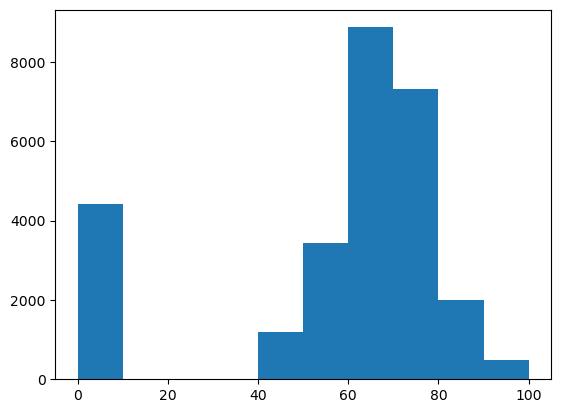

In [23]:
plt.hist(user_clean['weight'])

Weight is unlikley to be less than 20 kg, so I will remove these points.


(array([ 499.,  685., 1368., 6118., 4826., 4684., 2633., 1464.,  780.,
         250.]),
 array([ 40.,  46.,  52.,  58.,  64.,  70.,  76.,  82.,  88.,  94., 100.]),
 <BarContainer object of 10 artists>)

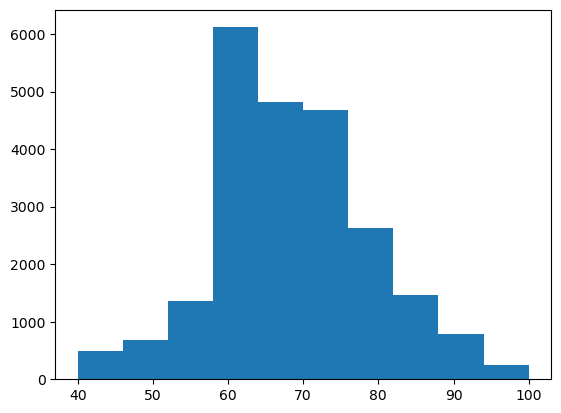

In [25]:
user_clean = user_clean[user_clean['weight'] > 20]
plt.hist(user_clean['weight'])

That looks better.

Now let's check the height data.

(array([1.9780e+03, 6.0000e+00, 1.1100e+02, 2.4000e+01, 3.4000e+01,
        2.8100e+02, 1.2032e+04, 8.7600e+03, 1.7000e+01, 6.4000e+01]),
 array([  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,
        229.5, 255. ]),
 <BarContainer object of 10 artists>)

count    23307.000000
mean       160.821127
std         50.498805
min          0.000000
25%        170.000000
50%        176.000000
75%        181.000000
max        255.000000
Name: height, dtype: float64

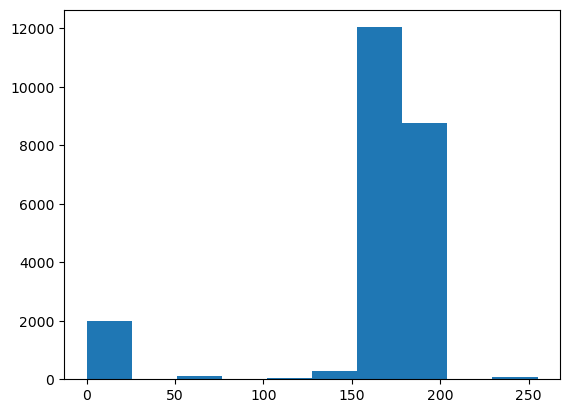

In [27]:
plt.hist(user_clean['height'])
user_clean['height'].describe()

To remove the potential for any data entry errors I will restrict height 
to be between 4-7.5 feet, and also convert to centimeters for BMI calculation.

(array([4.0000e+01, 7.4000e+01, 2.2300e+02, 1.2900e+03, 5.3920e+03,
        1.1897e+04, 3.7100e+03, 3.0300e+02, 1.3000e+01, 5.0000e+00]),
 array([1.21 , 1.314, 1.418, 1.522, 1.626, 1.73 , 1.834, 1.938, 2.042,
        2.146, 2.25 ]),
 <BarContainer object of 10 artists>)

count    22947.000000
mean         1.759819
std          0.090291
min          1.210000
25%          1.710000
50%          1.770000
75%          1.820000
max          2.250000
Name: height, dtype: float64

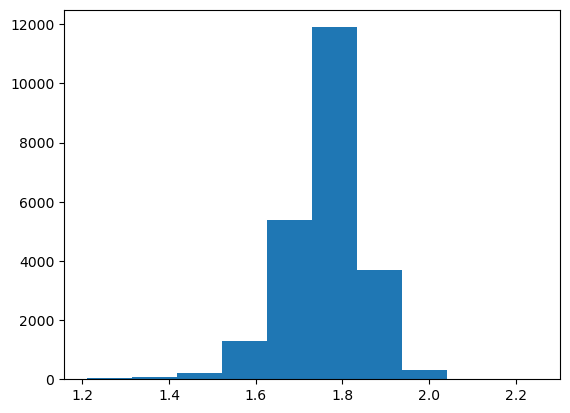

In [32]:
user_clean = user_clean[user_clean['height'] > 120]
user_clean = user_clean[user_clean['height'] < 228]
user_clean['height'] = user_clean['height']/100
plt.hist(user_clean['height'])
user_clean['height'].describe()

Instead of separately using height and weight as potentially highly correlated features in my model, I will calculate BMI for each user.

count    22947.000000
mean        20.173933
std          6.454024
min          0.000000
25%         19.895929
50%         21.561909
75%         23.040020
max         66.935319
Name: bmi, dtype: float64

(array([1.8440e+03, 4.3000e+01, 4.2460e+03, 1.6193e+04, 5.6100e+02,
        4.0000e+01, 9.0000e+00, 4.0000e+00, 3.0000e+00, 4.0000e+00]),
 array([ 0.        ,  6.69353186, 13.38706373, 20.08059559, 26.77412745,
        33.46765931, 40.16119118, 46.85472304, 53.5482549 , 60.24178676,
        66.93531863]),
 <BarContainer object of 10 artists>)

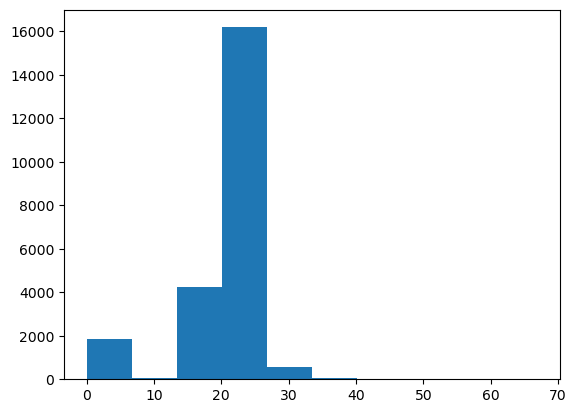

In [34]:
user_clean['bmi'] = user_clean['weight']/(user_clean['height']**2)
user_clean['bmi'].describe()
plt.hist(user_clean['bmi'])

Some of these BMI values are phylsioglically extreme and more likely to be typos instead of real values. I will filter BMIs to be between 15-40


count    21018.000000
mean        21.937919
std          2.356562
min         15.149602
25%         20.504934
50%         21.799308
75%         23.291230
max         39.728310
Name: bmi, dtype: float64

(array([ 405., 3535., 9132., 6225., 1315.,  252.,   96.,   34.,   12.,
          12.]),
 array([15.14960232, 17.60747305, 20.06534378, 22.52321451, 24.98108524,
        27.43895597, 29.8968267 , 32.35469743, 34.81256816, 37.27043889,
        39.72830962]),
 <BarContainer object of 10 artists>)

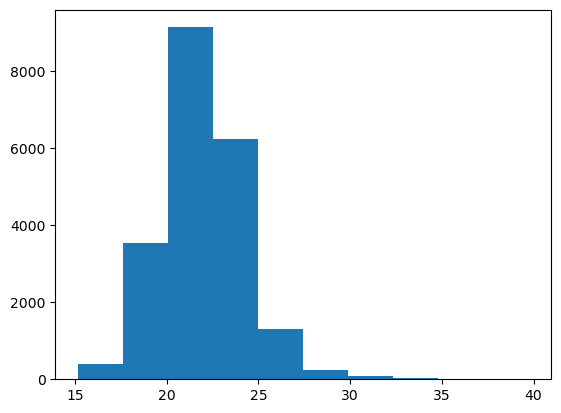

In [36]:
user_clean = user_clean[user_clean['bmi'] > 15]
user_clean = user_clean[user_clean['bmi'] < 40]
user_clean['bmi'].describe()
plt.hist(user_clean['bmi'])

Let's look at the type of climbs the users are recording. 

In [37]:
ascents.groupby(['climb_type']).size()

climb_type
0    2875675
1    1236202
dtype: int64

There are many more sport climbs than bouldering, but I will focus on bouldering datasince that is what I'm more familiar with
There are 1.2 million boulders ascents logged.

In [39]:
ascents_bouldering = ascents.loc[ascents['climb_type'] == 1]

user_ascent = pd.merge(user_clean, ascents_bouldering, 
                       left_on='id', right_on='user_id', how='inner', 
                       suffixes=('_user', '_ascents'))

In [41]:
user_ascent['id_user'].nunique()
user_ascent['id_ascents'].nunique()

9469

739554

After filtering to bouldering climbs and merging we have 9469 climbers with 739554 climbs

How many ascents does each climber have?

(array([421395., 169553.,  75168.,  31389.,  17211.,  13435.,   8705.,
             0.,      0.,   2698.]),
 array([1.0000e+00, 2.7070e+02, 5.4040e+02, 8.1010e+02, 1.0798e+03,
        1.3495e+03, 1.6192e+03, 1.8889e+03, 2.1586e+03, 2.4283e+03,
        2.6980e+03]),
 <BarContainer object of 10 artists>)

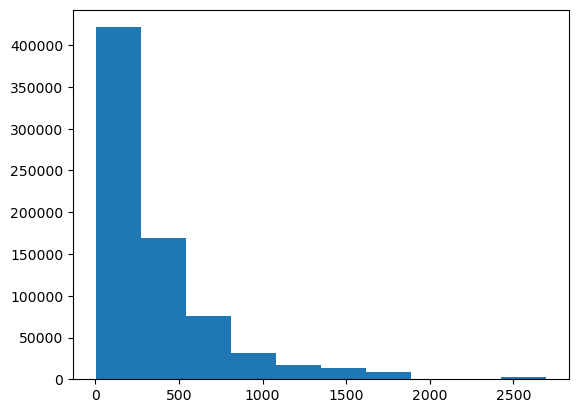

In [43]:
user_ascent['ascent_count'] = user_ascent.groupby(
    'id_user')['id_user'].transform('count')
plt.hist(user_ascent['ascent_count'])

Now let's calculate the age as another feature to use in the model. Age will be different for each ascent. First, we will need to clean the ascent data.

In [46]:
user_ascent['year'].describe()

count    739554.000000
mean       2010.991734
std          12.352945
min           0.000000
25%        2008.000000
50%        2011.000000
75%        2014.000000
max        2017.000000
Name: year, dtype: float64

Some of the ascents are at year 0, so I will filter to those only after completed after the year 1900.

In [47]:
user_ascent = user_ascent[user_ascent['year'] > 1900]
user_ascent['year'].describe()

count    739527.000000
mean       2011.062436
std           3.916223
min        1980.000000
25%        2008.000000
50%        2011.000000
75%        2014.000000
max        2017.000000
Name: year, dtype: float64

Now birth year will need to converted to pandas datatime so we can subtract ascent year and birth year to determine age of the climbers at each ascent.

In [49]:
#convert to pandas datetime to access birth year
user_ascent['birth'] = pd.to_datetime(user_ascent['birth'])
user_ascent['birth_year'] = user_ascent['birth'].dt.year

user_ascent['ascent_age'] = user_ascent['year'] - user_ascent['birth_year']
user_ascent['ascent_age'].describe()
user_ascent[['id_user','birth_year', 
             'year', 'ascent_age']].sort_values('ascent_age')


count    739527.000000
mean         27.366561
std           6.909296
min          -5.000000
25%          23.000000
50%          27.000000
75%          31.000000
max          72.000000
Name: ascent_age, dtype: float64

Several climbers completed climbs before they were born, so I will remove any rows where ascent age is less than 5

,id_user,birth_year,year,ascent_age
482823,28800,2004,2010,6
482825,28800,2004,2010,6
345782,19475,2000,2006,6
345791,19475,2000,2006,6
345790,19475,2000,2006,6
...,...,...,...,...
709659,57825,1951,2017,66
738920,66364,1949,2017,68
628037,43325,1940,2012,72
628035,43325,1940,2012,72


(array([2.66100e+03, 7.62230e+04, 2.30747e+05, 2.81062e+05, 1.00122e+05,
        3.67170e+04, 8.79900e+03, 1.56200e+03, 4.39000e+02, 5.10000e+01]),
 array([ 6. , 12.6, 19.2, 25.8, 32.4, 39. , 45.6, 52.2, 58.8, 65.4, 72. ]),
 <BarContainer object of 10 artists>)

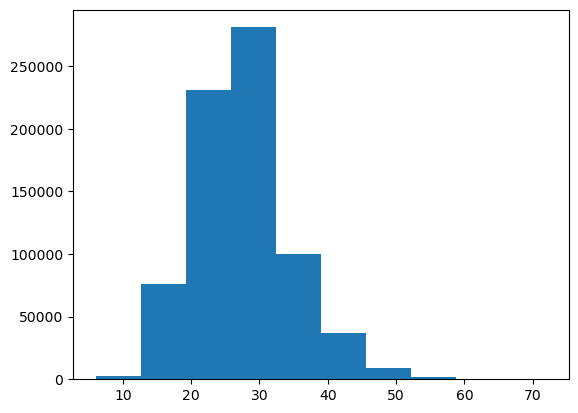

In [50]:
user_ascent = user_ascent[user_ascent['ascent_age'] > 5]

user_ascent[['id_user','birth_year', 
             'year', 'ascent_age']].sort_values('ascent_age')

plt.hist(user_ascent['ascent_age'])

I'll now calculate years of climbing experience at each ascent. This value will be different at each 
ascent. I'll first check the started column and remove any climbers that started climbing before 1900.

In [51]:
user_ascent['started'].describe()
user_ascent = user_ascent[user_ascent['started'] > 1900]
user_ascent['started'].describe()

count    738383.000000
mean       1866.226224
std         503.589656
min           0.000000
25%        1997.000000
50%        2002.000000
75%        2007.000000
max        2050.000000
Name: started, dtype: float64

count    688275.000000
mean       2002.091777
std           7.050801
min        1914.000000
25%        1998.000000
50%        2003.000000
75%        2007.000000
max        2050.000000
Name: started, dtype: float64

In [52]:
user_ascent['years_exp'] = user_ascent['year'] - user_ascent['started']
user_ascent['years_exp'].describe()

count    688275.000000
mean          8.835313
std           6.514974
min         -42.000000
25%           4.000000
50%           7.000000
75%          12.000000
max         100.000000
Name: years_exp, dtype: float64

Some climbers have negative climbing experience, so I will remove these rows.

count    681385.000000
mean          8.940418
std           6.429354
min           1.000000
25%           4.000000
50%           7.000000
75%          12.000000
max         100.000000
Name: years_exp, dtype: float64

(array([4.65062e+05, 1.80163e+05, 2.90320e+04, 6.13900e+03, 6.91000e+02,
        2.50000e+01, 2.37000e+02, 0.00000e+00, 1.00000e+00, 3.50000e+01]),
 array([  1. ,  10.9,  20.8,  30.7,  40.6,  50.5,  60.4,  70.3,  80.2,
         90.1, 100. ]),
 <BarContainer object of 10 artists>)

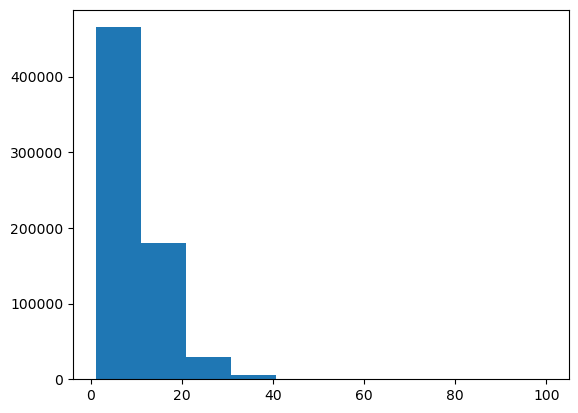

In [54]:
user_ascent = user_ascent[user_ascent['years_exp'] > 0]
user_ascent['years_exp'].describe()
plt.hist(user_ascent['years_exp'])

There still look there are some extreme values, such as climbers that have 100 years of experience. I'll remove ascents where years of experience is greater than ascent age.

,id_user,birth_year,year,ascent_age,years_exp
345787,19475,2000,2006,6,3
345796,19475,2000,2006,6,3
345791,19475,2000,2006,6,3
345790,19475,2000,2006,6,3
345788,19475,2000,2006,6,3
...,...,...,...,...,...
709657,57825,1951,2017,66,49
709656,57825,1951,2017,66,49
709672,57825,1951,2017,66,49
723451,60319,1951,2017,66,6


(array([2.91969e+05, 2.05453e+05, 1.19042e+05, 3.84960e+04, 1.50730e+04,
        6.40000e+03, 2.28800e+03, 2.66000e+02, 3.75000e+02, 3.00000e+00]),
 array([ 1. ,  6.5, 12. , 17.5, 23. , 28.5, 34. , 39.5, 45. , 50.5, 56. ]),
 <BarContainer object of 10 artists>)

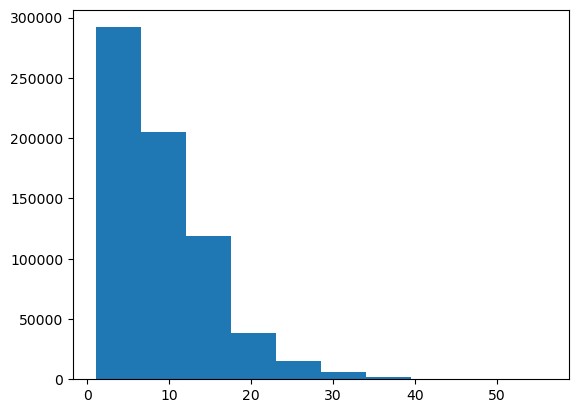

In [56]:
user_ascent[['id_user','birth_year', 'year', 
             'ascent_age', 'years_exp']].sort_values('ascent_age')
user_ascent = user_ascent[user_ascent['years_exp'] < user_ascent['ascent_age']]
plt.hist(user_ascent['years_exp'])

Next I will merge in methods and grades tables.

In [58]:
user_ascent_grade = pd.merge(user_ascent, grades[['id', 'usa_boulders']], 
                             left_on='grade_id', right_on='id', how='inner', 
                             suffixes=('_ascents', '_grades'))

user_ascent_grade_method = pd.merge(user_ascent_grade, 
                                    method[['id', 'name']], left_on='method_id',
                                    right_on='id', how='inner', 
                                    suffixes=('_grades','_methods'))

#check results of merge
user_ascent_grade_method[['user_id', 'id_ascents', 'id_grades', 'usa_boulders',
                          'id_methods', 'name_methods']]

,user_id,id_ascents,id_grades,usa_boulders,id_methods,name_methods
0,1,37265,44,V5,1,Redpoint
1,1,37266,44,V5,1,Redpoint
2,1,44846,44,V5,1,Redpoint
3,1,58369,44,V5,1,Redpoint
4,1,59957,44,V5,1,Redpoint
...,...,...,...,...,...,...
679360,17531,1374572,53,V8,3,Onsight
679361,17531,1374579,53,V8,3,Onsight
679362,31301,1564382,53,V8,3,Onsight
679363,1263,572473,64,V12,3,Onsight


id_user                          int64
first_name                      object
last_name                       object
city                            object
country_user                    object
sex                              int64
height                         float64
weight                           int64
started                          int64
competitions                    object
occupation                      object
sponsor1                        object
sponsor2                        object
sponsor3                        object
best_area                       object
worst_area                      object
guide_area                      object
interests                       object
birth                   datetime64[ns]
presentation                    object
deactivated                      int64
anonymous                        int64
bmi                            float64
id_ascents                       int64
user_id                          int64
grade_id                 

Now I'm going to clean up the grades column. I'm going to condense some of the grades and convert them to integers.

In [59]:
#remove na from grades
user_ascent_grade_method = user_ascent_grade_method[user_ascent_grade_method['usa_boulders'].notna()]

#lets check how many users and ascents we lost after all of the data cleaning

#convert grades with multiple to be one grade, using the lower grade
user_ascent_grade_method['usa_boulders_new'] = np.where(user_ascent_grade_method['usa_boulders'] == 'V0-',
             'VB', np.where(user_ascent_grade_method['usa_boulders'] == 'V3/4',
                      'V3', np.where(user_ascent_grade_method['usa_boulders'] == 'V4/V5',
                               'V4', np.where(user_ascent_grade_method['usa_boulders'] == 'V5/V6',
                                        'V5', np.where(user_ascent_grade_method['usa_boulders'] == 'V8/9',
                                                 'V8', user_ascent_grade_method['usa_boulders'])))))

#create numeric version of grades
user_ascent_grade_method['usa_boulders_numeric'] = user_ascent_grade_method['usa_boulders_new'].str.replace("V", "")
user_ascent_grade_method['usa_boulders_numeric'] = user_ascent_grade_method['usa_boulders_numeric'].str.replace("B", "-1")
user_ascent_grade_method['usa_boulders_numeric']  = user_ascent_grade_method['usa_boulders_numeric'].astype(int)


user_ascent_grade_method['usa_boulders'].unique()
user_ascent_grade_method['usa_boulders_new'].unique()
user_ascent_grade_method['usa_boulders_numeric'].unique()

array(['V5', 'V3/4', 'V3', 'V4', 'V1', 'V0', 'V2', 'VB', 'V7', 'V6',
       'V4/V5', 'V5/V6', 'V8/9', 'V9', 'V11', 'V10', 'V8', 'V12', 'V13',
       'V14', 'V15', 'V16', 'V17', 'V0-'], dtype=object)

array(['V5', 'V3', 'V4', 'V1', 'V0', 'V2', 'VB', 'V7', 'V6', 'V8', 'V9',
       'V11', 'V10', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17'],
      dtype=object)

array([ 5,  3,  4,  1,  0,  2, -1,  7,  6,  8,  9, 11, 10, 12, 13, 14, 15,
       16, 17])

Let's look at how many ascents there are for each grade.

<AxesSubplot:xlabel='usa_boulders_new'>

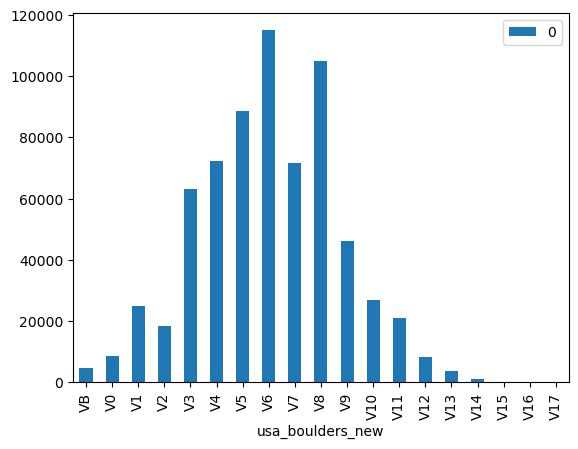

In [60]:
#set order of grades
grades_order = ["VB", "V0", "V1", "V2", "V3", "V4", "V5", "V6", "V7", 
                "V8", "V9", "V10", "V11", "V12", "V13", "V14", "V15", "V16", "V17"]


grades_summary = pd.DataFrame(user_ascent_grade_method.groupby('usa_boulders_new').size())
grades_summary.index.name = 'usa_boulders_new'
grades_summary.reset_index(inplace=True)
grades_summary.set_index('usa_boulders_new').loc[grades_order].plot(kind="bar")

How are ascents completed?

name_methods
Flash       100725
Onsight      49795
Redpoint    528560
dtype: int64

<AxesSubplot:xlabel='name_methods'>

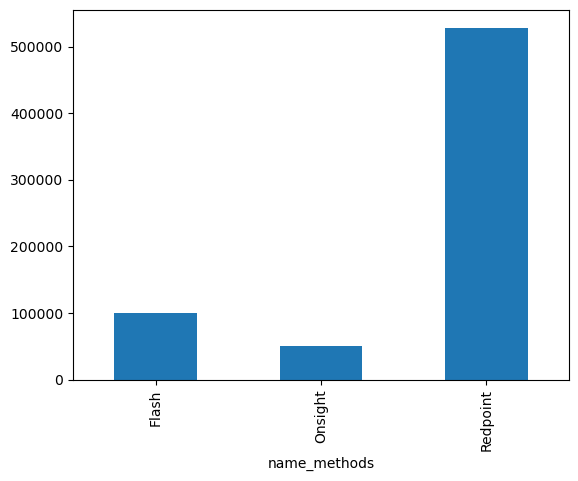

In [61]:
#toprope is not supposed to be in the section of boulders, so I will remove ascents with these labels
user_ascent_grade_method = user_ascent_grade_method[user_ascent_grade_method['name_methods'].isin(
    ['Flash', 'Onsight', 'Redpoint'])]

methods_summary = user_ascent_grade_method.groupby('name_methods').size()
methods_summary
methods_summary.plot(kind='bar')

I'm going to identify the max grade completed per user and create a column with the date of the first time the maximum grade was completed (in the event a climber has multiple ascents of the max grade) 

In [62]:
#identify max grade completed per user
user_ascent_grade_method['max_grade'] = user_ascent_grade_method['usa_boulders_numeric'].groupby(
    user_ascent_grade_method['id_user']).transform('max')

#create column with date of first max grade ascent
user_ascent_grade_method['max_grade_date']=user_ascent_grade_method.sort_values(
    by=['usa_boulders_numeric', 'year'],ascending=[False, True]).groupby(
        'id_user')['year'].transform('first')

#remove any ascents that were completed after the max grade date 
user_ascent_grade_method = user_ascent_grade_method[user_ascent_grade_method['year'] <= user_ascent_grade_method['max_grade_date']]


Now I'm going to determine the years of experience and age for a climber has at the time they completed their max grade. If there is a tie for a user by max grade, I'll select the ascent that was completed first. I don't want to use total years of experience because this could include data from the future in the model.

In [67]:
user_ascent_grade_method['years_exp_max_grade']=user_ascent_grade_method.sort_values(
    by=['usa_boulders_numeric', 'year'],ascending=[False, True]).groupby(
        'id_user')['years_exp'].transform('first')

user_ascent_grade_method['age_max_grade']=user_ascent_grade_method.sort_values(
    by=['usa_boulders_numeric', 'year'],ascending=[False, True]).groupby(
        'id_user')['ascent_age'].transform('first')


#check number ascents at time max grade was completed
user_ascent_grade_method['ascents_max_grade'] = user_ascent_grade_method.groupby(
    'id_user')['id_user'].transform('count')

Next I will count the number of redpoints, flashes, and onsights for each climber. Each ascent can be cateogrized as one of these types.

flash - completed on first try but have seen others do it or were told how to do it

redpoint - completed climb after having practiced the route

onsight - completed first try without seeing any else do it or being told how to do it


In [68]:
#pivot table to find number of redpoints, flashes, and onsights
ascent_type_sums = user_ascent_grade_method.pivot_table(
    values='ascent_count', index='user_id', columns='name_methods',
    fill_value=0, aggfunc='sum')

user_ascent_grade_method = pd.merge(user_ascent_grade_method, ascent_type_sums, on='user_id')

#check results
#user_ascent_grade_method[user_ascent_grade_method['user_id'] == 3][['user_id', 'ascents_max_grade', 'Redpoint', 'Onsight', 'Flash']]


What countries are the climbers from?

<AxesSubplot:xlabel='Country', ylabel='Number of users'>

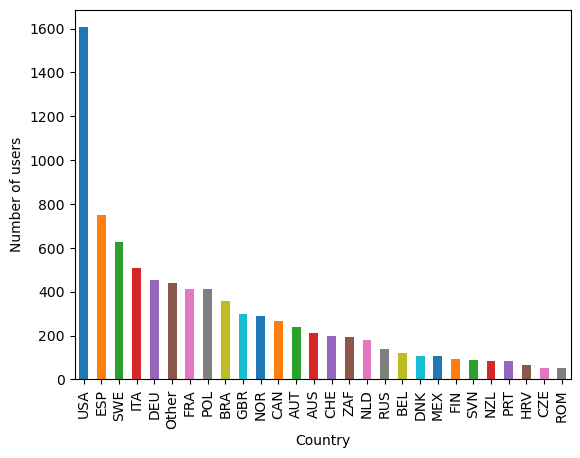

In [70]:
countries =  pd.DataFrame(user_ascent_grade_method.drop_duplicates(
    subset=['id_user']).groupby('country_user').size())

countries.index.name = 'country_user'
countries.reset_index(inplace=True)
countries = countries.rename(columns={countries.columns[1]: 'number_of_users'})

#combine countries with less than 10 into "other" category
countries['country_user'] = np.where(countries['number_of_users'] < 50, 
                                     'Other', countries['country_user'])

countries = countries.groupby('country_user')['number_of_users'].sum().sort_values(ascending=False)
cmap = plt.cm.tab10
colors = cmap(np.arange(len(countries)) % cmap.N)
countries.plot(kind='bar', color=colors, xlabel='Country', ylabel='Number of users' )

Now I will prepare the outcome variable for binary regression. Intitial testing with this dataset showed that multinomial regression would not be feasible with this dataset, so I will condense the outcome categories into high and low based on the median max grade.

8.0

/var/folders/h2/yfy4kgfn3l7_c6byc_fnzq340000gn/T/ipykernel_16781/2082596101.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_duplicate_users['max_grade_combined'] = np.where(


<AxesSubplot:xlabel='Max Grade', ylabel='Number of climbers'>

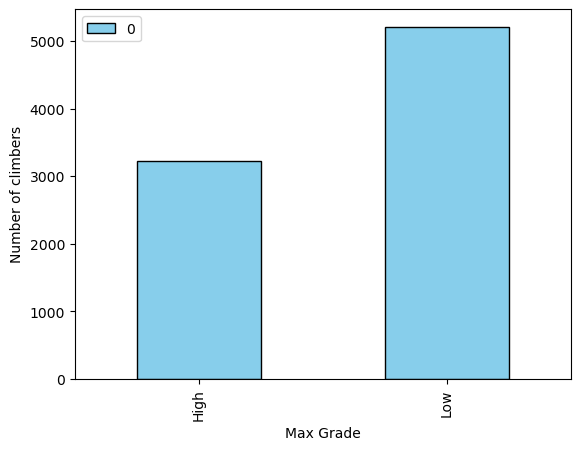

In [72]:
no_duplicate_users = user_ascent_grade_method.drop_duplicates(subset=['id_user'])

np.median(no_duplicate_users['max_grade'])
no_duplicate_users['max_grade_combined'] = np.where(
    no_duplicate_users['max_grade'].isin([-1,0,1,2,3,4,5,6,7,8]), 'Low', 'High')

max_grade_summary = pd.DataFrame(no_duplicate_users.groupby('max_grade_combined').size())
max_grade_summary.index.name = 'max_grade_combined'
max_grade_summary.reset_index(inplace=True)

max_grade_summary.set_index('max_grade_combined').plot(
    kind='bar',xlabel='Max Grade', ylabel='Number of climbers', 
    color='skyblue', edgecolor='k' )

The classes are not perfectly balanced, so we will have to keep this in mind. I will now subset the data to only the features I will use for prediction and the outcome variable

In [76]:
input_df = no_duplicate_users[['id_user', 'sex', 'bmi', 'years_exp_max_grade', 
                               'age_max_grade', 'Redpoint', 'Onsight','Flash', 
                               'max_grade_combined']]

input_df.head(10)

#convert outcome category to indicator variable
#High = 1
#Low =0 
input_df['max_grade_outcome'] = pd.get_dummies(
    input_df['max_grade_combined'])['High']

x =input_df[['sex', 'bmi', 'years_exp_max_grade', 
             'age_max_grade', 'Redpoint', 'Onsight','Flash']]
y= input_df['max_grade_outcome']
x
y

,id_user,sex,bmi,years_exp_max_grade,age_max_grade,Redpoint,Onsight,Flash,max_grade_combined
0,1,0,23.301095,6,26,1769,549,122,Low
40,3,0,24.074074,6,28,120,0,24,Low
52,10,0,22.589551,15,42,3486,664,332,Low
106,16,0,21.705129,15,38,4125,150,300,High
167,28,0,20.987654,25,41,59055,30099,24765,High
466,54,0,21.798202,8,30,52326,17442,8398,High
708,80,0,21.798202,6,25,460,0,69,Low
731,86,0,23.991213,10,28,441,0,0,Low
740,89,0,21.295295,22,40,8092,0,1785,High
823,110,0,23.836735,6,26,1173,0,51,Low


/var/folders/h2/yfy4kgfn3l7_c6byc_fnzq340000gn/T/ipykernel_16781/3326142348.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_df['max_grade_outcome'] = pd.get_dummies(


,sex,bmi,years_exp_max_grade,age_max_grade,Redpoint,Onsight,Flash
0,0,23.301095,6,26,1769,549,122
40,0,24.074074,6,28,120,0,24
52,0,22.589551,15,42,3486,664,332
106,0,21.705129,15,38,4125,150,300
167,0,20.987654,25,41,59055,30099,24765
...,...,...,...,...,...,...,...
467987,1,18.289895,8,28,0,1,0
467988,0,20.305175,15,30,0,4,0
467990,0,21.222808,6,15,0,1,0
467991,0,20.571429,13,29,0,1,0


0         0
40        0
52        0
106       1
167       1
         ..
467987    1
467988    1
467990    1
467991    0
467992    0
Name: max_grade_outcome, Length: 8427, dtype: uint8

Does the data separate used an unsupervised analysis?

<AxesSubplot:xlabel='principal component 1', ylabel='principal component 2'>

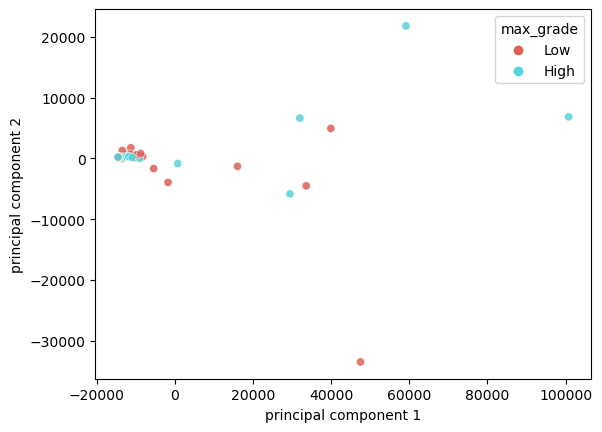

In [77]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)

principal_df = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
principal_df['max_grade'] = input_df['max_grade_combined']

sns.scatterplot(
    x="principal component 1", y="principal component 2",
    hue="max_grade",
    palette=sns.color_palette("hls", 2),
    data=principal_df,
    legend="full",
    alpha=0.85
)

It does not appear to separate by high vs low on the first two components. Let's see if a supervised analysis performs better and can spearate climbers by these two groups.

My first choice is to use logistic regression since it  provides explainable outcomes, so I will check if this algorithm is suitable

There are 5 assumptions to check before using logistic regression:
-multicollinearity
-linearity
-outliers
-indepdence 
-binary outcome variable


Lets check features for multicollineraity using pearson's correlation.

<AxesSubplot:>

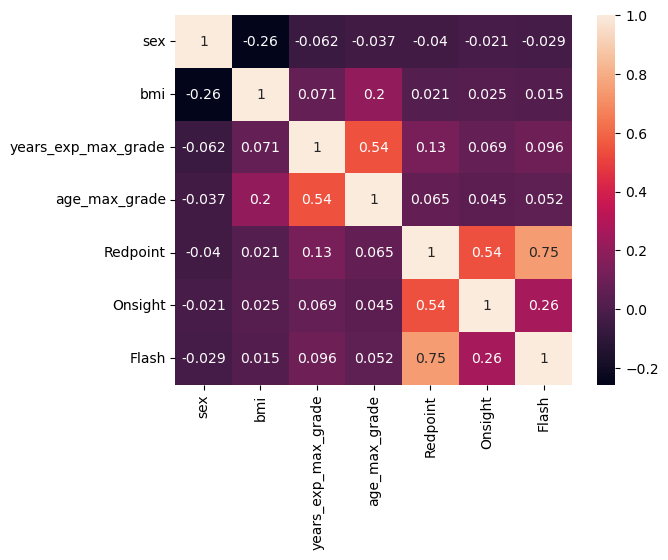

In [78]:
corr = x.corr()
# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns, annot=True)

Redpoint and flash have a high correlation, which would not work well with logistic regression.

Logistic regression also assumes features are indepdent of one another. In this dataset, the
features do not come from repeated mesaruremtns of the same feature over time, and they are independent of one another.

Logistic regression assumes the relationship between each continuous feature
and the logit of the outcome variable

<AxesSubplot:xlabel='age_max_grade', ylabel='max_grade_outcome'>

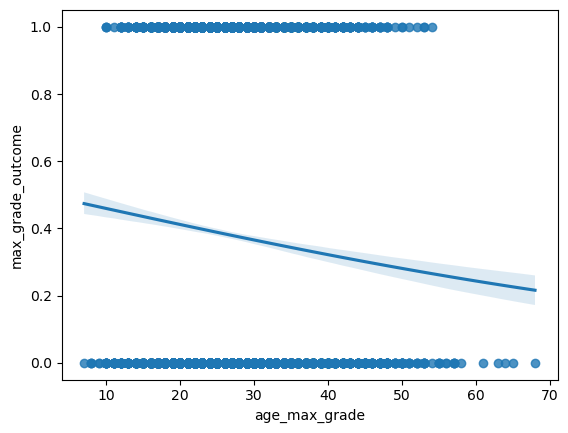

In [85]:
sns.regplot(x= input_df['age_max_grade'], y=input_df['max_grade_outcome'], logistic= True)


<AxesSubplot:xlabel='years_exp_max_grade', ylabel='max_grade_outcome'>

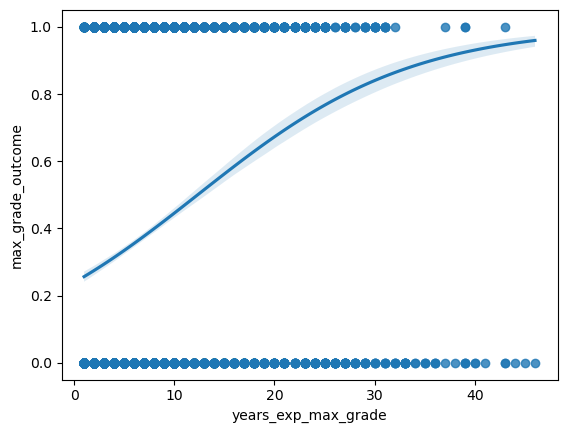

In [86]:
sns.regplot(x= input_df['years_exp_max_grade'], y=input_df['max_grade_outcome'], logistic= True)


<AxesSubplot:xlabel='bmi', ylabel='max_grade_outcome'>

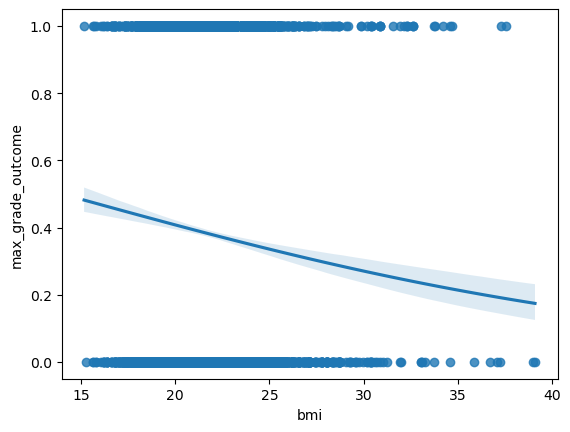

In [87]:
sns.regplot(x= input_df['bmi'], y=input_df['max_grade_outcome'], logistic= True)


<AxesSubplot:xlabel='Onsight', ylabel='max_grade_outcome'>

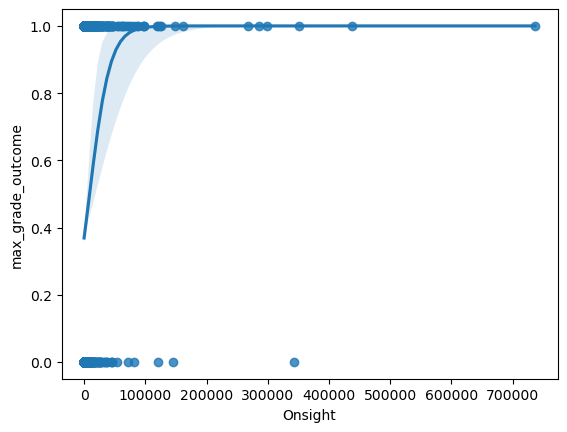

In [88]:
sns.regplot(x= input_df['Onsight'], y=input_df['max_grade_outcome'], logistic= True)


<AxesSubplot:xlabel='Flash', ylabel='max_grade_outcome'>

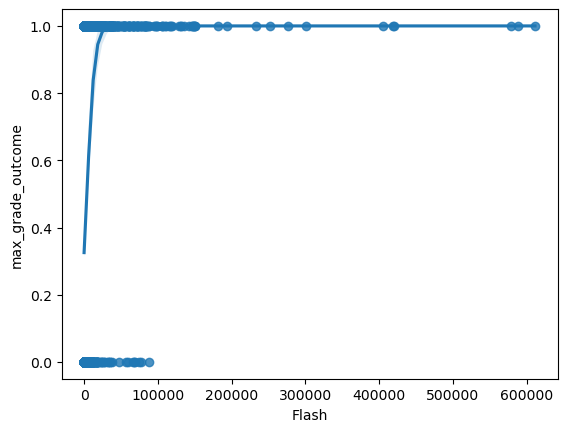

In [89]:
sns.regplot(x= input_df['Flash'], y=input_df['max_grade_outcome'], logistic= True)


While most of the features appear to meet this assumption, the number of flashes and onsights looks a little off. I will continue to test the other fewatures to see if logistic regression
is appropriate. 

Logistic regression does not work well with outliers. Let's check these features for outliers.

<AxesSubplot:>

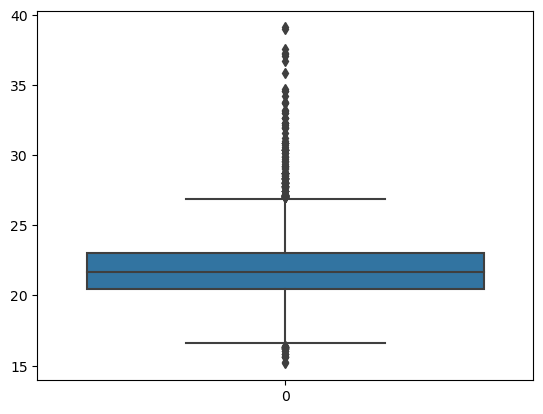

In [90]:
sns.boxplot(data= x['bmi'])


<AxesSubplot:>

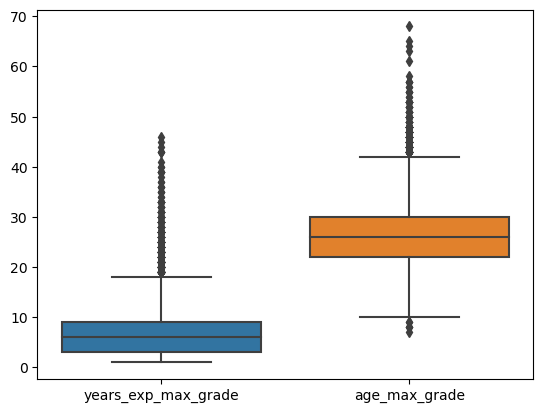

In [91]:
sns.boxplot(data= x[['years_exp_max_grade', 'age_max_grade']])


<AxesSubplot:>

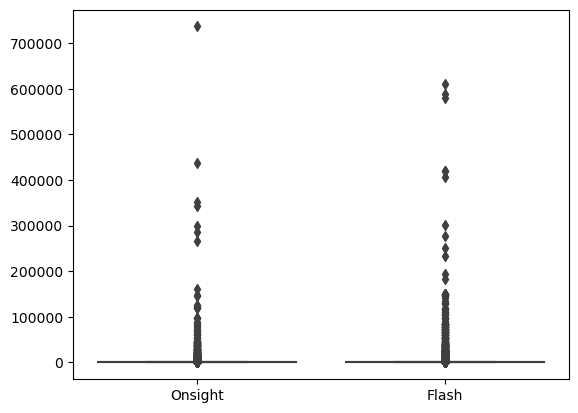

In [92]:
sns.boxplot(data= x[['Onsight', 'Flash']])

There are quite a few outliers across all of the categories with many of the features 
skewed toward higher values. Given that a few of the assumptions of logsitic regression have been violated, logistic regression is not the best algorithm for this analysis.

Instead, I will try svm, random forest, and xgboost since they are more robust to outliers and mutlicollinearity, even though
they are at the expense of feature explainability.

Ill first build a model using svm apply gridsearch for hyperparamter tuning. I am checking variables acrossthe follow paramters:
    kernel, C, and gamma.

In [ ]:
#svm hyperparamter tuning
model = SVC()
kernel = ['poly', 'rbf', 'sigmoid']
C = [50, 10, 1.0, 0.1, 0.01]
gamma = ['scale']
# define grid search
grid = dict(kernel=kernel,C=C,gamma=gamma)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, cv=cv, scoring='accuracy',error_score=0)
grid_result_svm = grid_search.fit(x, y)
# summarize results
print("Best: %f using %s" % (grid_result_svm.best_score_, grid_result_svm.best_params_))
means = grid_result_svm.cv_results_['mean_test_score']
stds = grid_result_svm.cv_results_['std_test_score']
params = grid_result_svm.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

For xgboost I will check many parameters, including n_estimators, leanring_rate, subsample, and max_depth.

In [ ]:
#xgboost   
model = XGBClassifier()
n_estimators = [10, 100, 1000]
learning_rate = [0.001, 0.01, 0.1]
subsample = [0.5, 0.7, 1.0]
max_depth = [3, 7, 9]
# define grid search
grid = dict(learning_rate=learning_rate, n_estimators=n_estimators, subsample=subsample, max_depth=max_depth)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, cv=cv, scoring='accuracy',error_score=0)
grid_result_xgb = grid_search.fit(x, y)
# summarize results
print("Best: %f using %s" % (grid_result_xgb.best_score_, grid_result_xgb.best_params_))
means = grid_result_xgb.cv_results_['mean_test_score']
stds = grid_result_xgb.cv_results_['std_test_score']
params = grid_result_xgb.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

For random forest I will check across n_estimators and max_features.

In [ ]:
#randomforest hyperparamter tuning
model = RandomForestClassifier()
n_estimators = [10, 100, 1000]
max_features = ['sqrt', 'log2']
# define grid search
grid = dict(n_estimators=n_estimators,max_features=max_features)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, cv=cv, scoring='accuracy',error_score=0)
grid_result_rf = grid_search.fit(x, y)
#summarize results
print("Best: %f using %s" % (grid_result_rf.best_score_, grid_result_rf.best_params_))
means = grid_result_rf.cv_results_['mean_test_score']
stds = grid_result_rf.cv_results_['std_test_score']
params = grid_result_rf.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

I'll assess the results across all algorithms and hyperparamters to see which one would be best to use predict maximum bouldering grade based on these features.

In [ ]:
svm_accuracy = pd.DataFrame(grid_result_svm.cv_results_['mean_test_score'])
svm_accuracy['algorithm'] = 'SVM'

xgb_accuracy = pd.DataFrame(grid_result_xgb.cv_results_['mean_test_score'])
xgb_accuracy['algorithm'] = 'XGB'

rf_accuracy = pd.DataFrame(grid_result_rf.cv_results_['mean_test_score'])
rf_accuracy['algorithm'] = 'RF'

accuracy_comparison = pd.concat([svm_accuracy, xgb_accuracy, rf_accuracy])
accuracy_comparison = accuracy_comparison.rename(columns={accuracy_comparison.columns[0]: 'accuracy'})

accuracy_comparison.sort_values('accuracy', ascending=False).head(10)

sns.boxplot(data= accuracy_comparison, x='algorithm', y='accuracy')
sns.stripplot(data= accuracy_comparison, x='algorithm', y='accuracy', color='black',  alpha = 0.6)

It looks like xgboost is the best perfomring model. Lets build a model using these paramters and make some predictions.

In [ ]:
#define model with best parameters
print(grid_result_xgb.best_params_)
best_xgb_model = grid_result_xgb.best_estimator_

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

#feature importance
best_xgb_model.fit(x_train, y_train)
plot_importance(best_xgb_model)



These are the most important features.

In [ ]:
# Generate predictions with the best model
y_pred = best_xgb_model.predict(x_test)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)


In the future, it would be great to identify more features that could improve accuracy, deploy this model in an application that tracks climbing stats and predicts maximum bouldering grade, as well as adjust to model from binary to multinomial regression make more informative predictions.